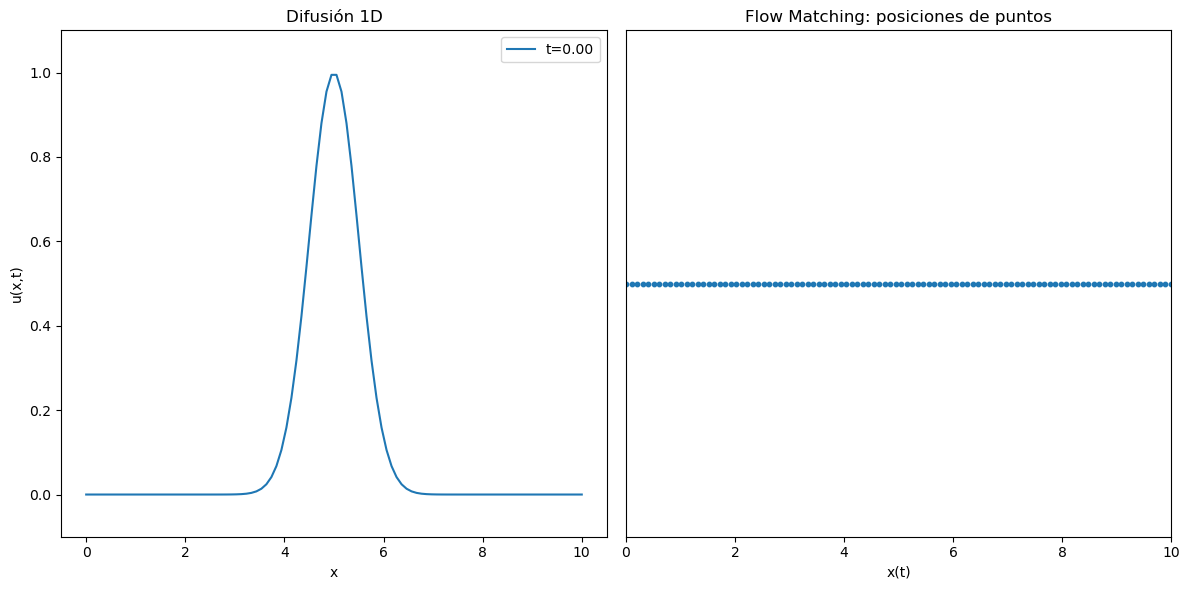

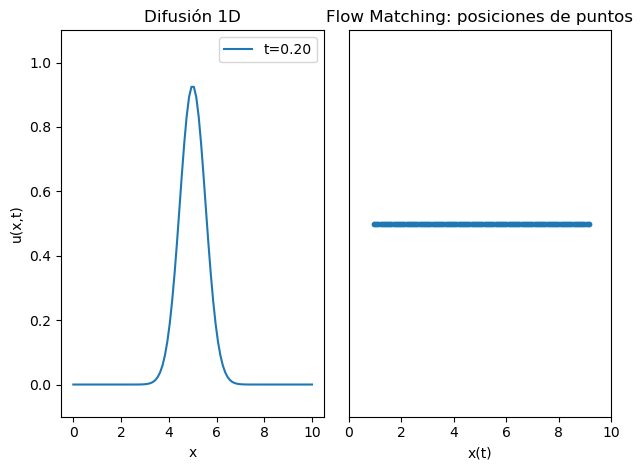

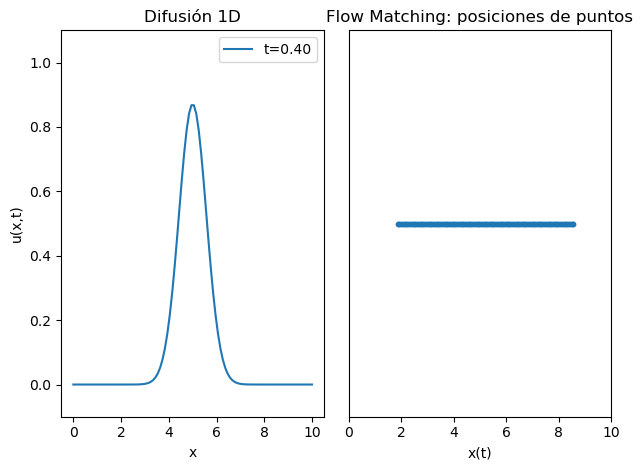

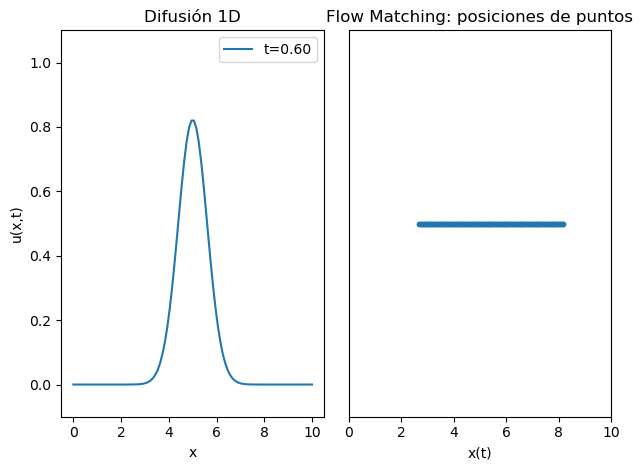

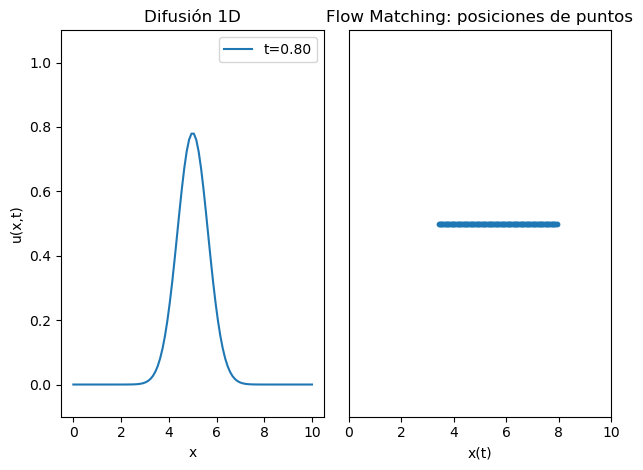

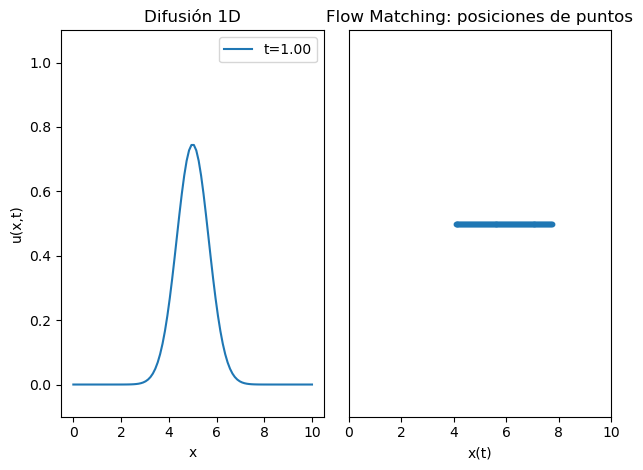

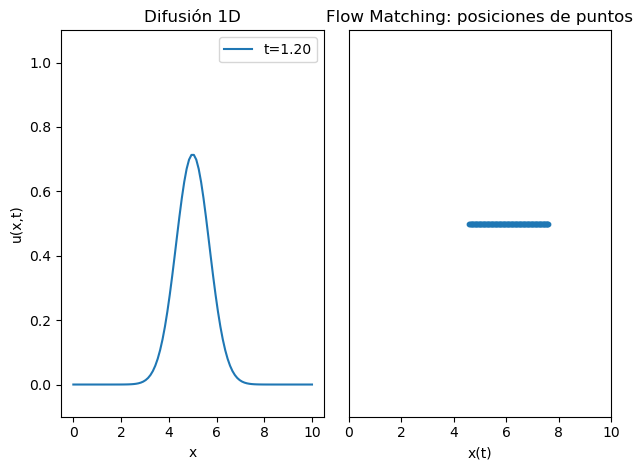

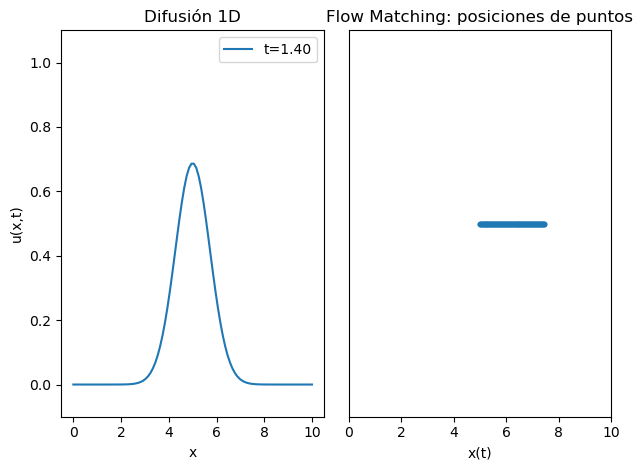

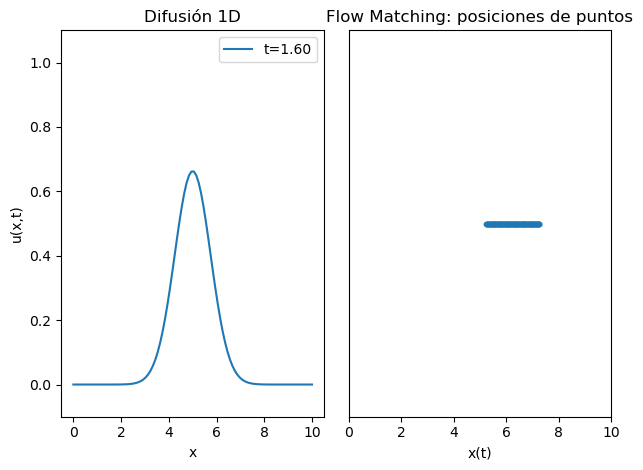

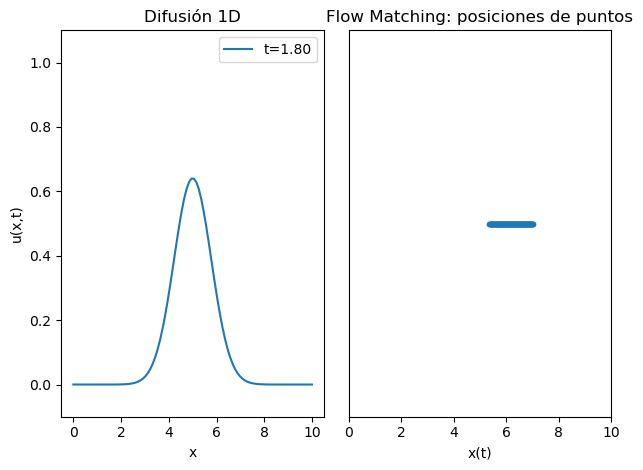

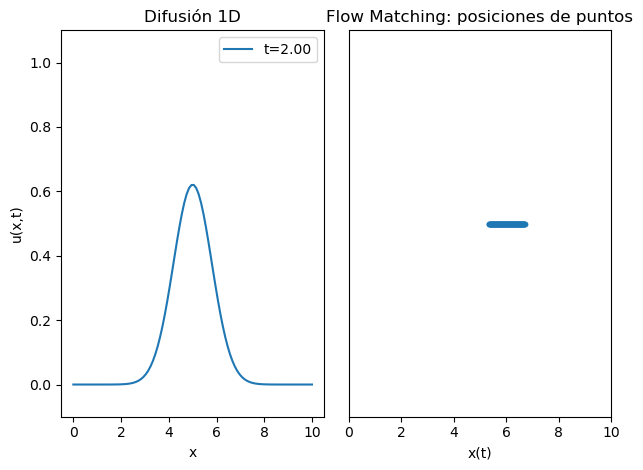

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parámetros generales ---
L = 10.0          # longitud del dominio espacial
Nx = 100          # cantidad de puntos espaciales
dx = L / (Nx - 1) # paso espacial
x = np.linspace(0, L, Nx)

T = 2.0           # tiempo total de simulación
dt = 0.001        # paso temporal
Nt = int(T / dt)  # cantidad de pasos temporales

D = 0.1           # coeficiente de difusión

# --- Condiciones iniciales (distribución gaussiana) ---
def gauss(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma)**2)

u0 = gauss(x, mu=L/2, sigma=0.5)  # para difusión

# --- Método de diferencias finitas explícito para difusión 1D ---
def diffusion_step(u, D, dt, dx):
    u_new = u.copy()
    coeff = D * dt / dx**2
    for i in range(1, len(u)-1):
        u_new[i] = u[i] + coeff * (u[i+1] - 2*u[i] + u[i-1])
    # Condiciones de frontera Dirichlet (fijas)
    u_new[0] = 0
    u_new[-1] = 0
    return u_new

# --- Flow matching simple en 1D ---
# Campo vectorial: v(t,x) = -lambda * (x - mu(t))
lambda_ = 1.0
def mu(t):
    return L/2 + 2.0 * np.sin(np.pi * t / T)

def v(t, x):
    return -lambda_ * (x - mu(t))

# RK4 para ODE
def rk4_step(x, t, dt, v_func):
    k1 = v_func(t, x)
    k2 = v_func(t + dt/2, x + dt/2 * k1)
    k3 = v_func(t + dt/2, x + dt/2 * k2)
    k4 = v_func(t + dt, x + dt * k3)
    return x + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

# --- Simulación ---

# Inicializamos las posiciones para flow matching (mismos puntos que para difusión)
X = x.copy()

# Inicializamos solución difusión
U = u0.copy()

# Para graficar cada cierto tiempo
plot_steps = Nt // 10

plt.figure(figsize=(12,6))

for n in range(Nt):
    t = n * dt
    # Paso difusión
    U = diffusion_step(U, D, dt, dx)
    # Paso flow matching
    X = rk4_step(X, t, dt, v)
    
    # Graficar cada 10% de la simulación
    if n % plot_steps == 0 or n == Nt-1:
        plt.clf()
        plt.subplot(1,2,1)
        plt.plot(x, U, label=f't={t:.2f}')
        plt.title('Difusión 1D')
        plt.xlabel('x')
        plt.ylabel('u(x,t)')
        plt.ylim(-0.1, 1.1)
        plt.legend()

        plt.subplot(1,2,2)
        plt.scatter(X, np.zeros_like(X), marker='o', s=10)
        plt.title('Flow Matching: posiciones de puntos')
        plt.xlabel('x(t)')
        plt.yticks([])
        plt.xlim(0, L)
        plt.tight_layout()
        plt.pause(0.1)

plt.show()


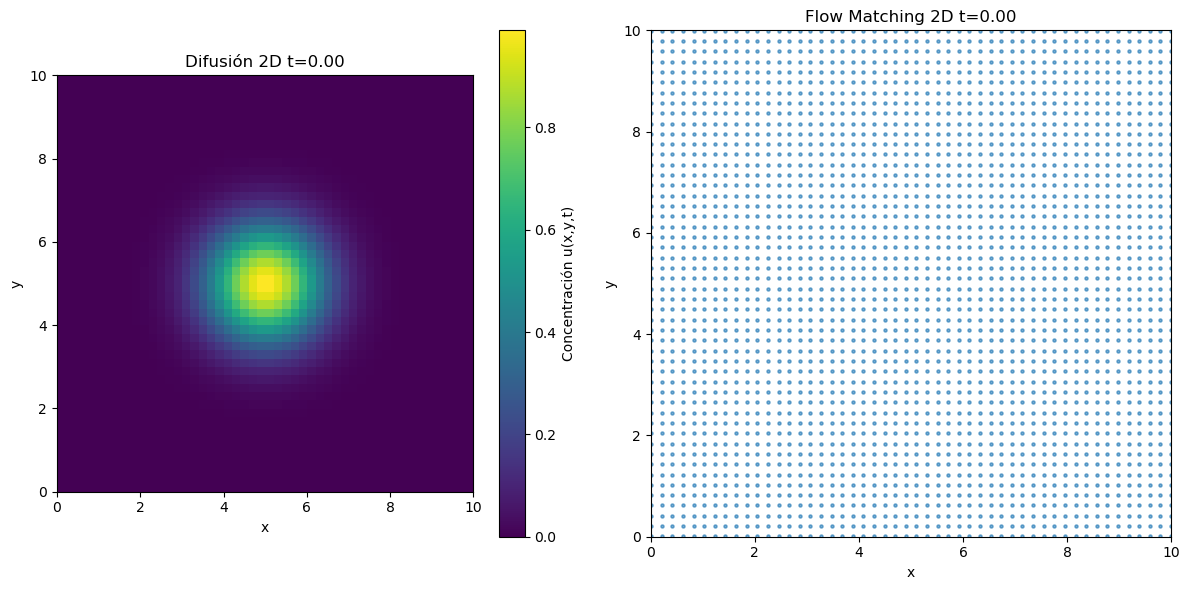

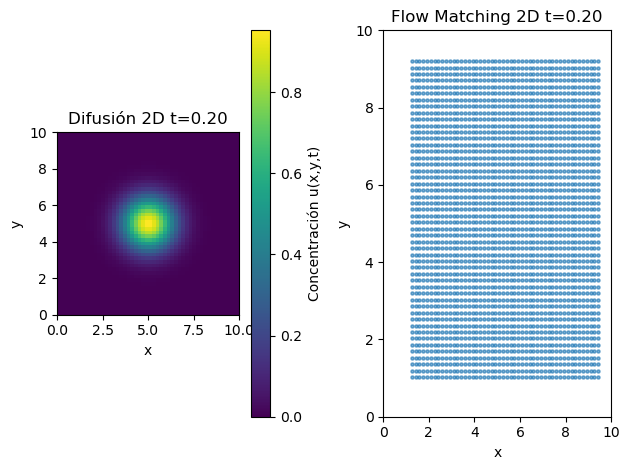

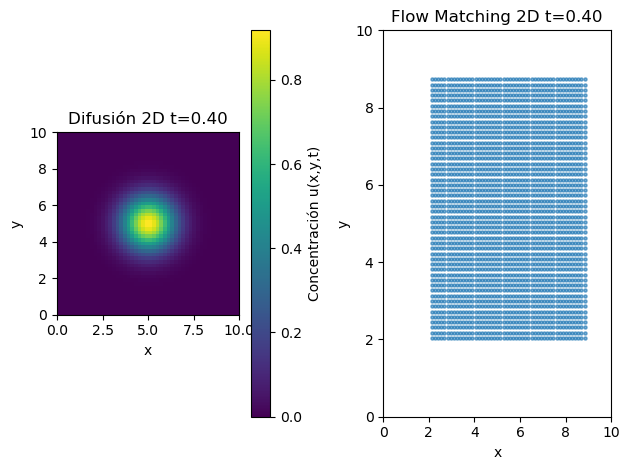

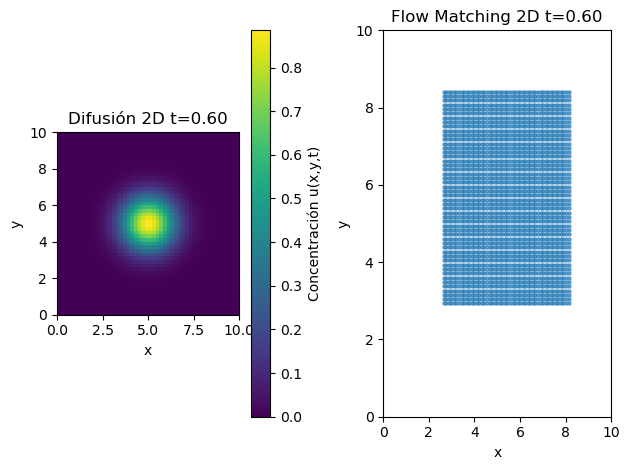

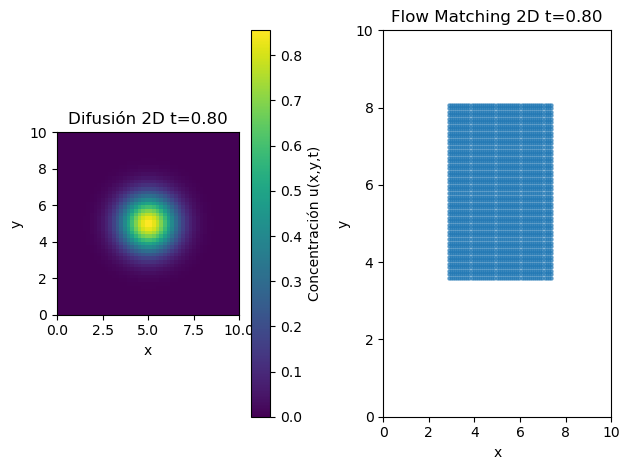

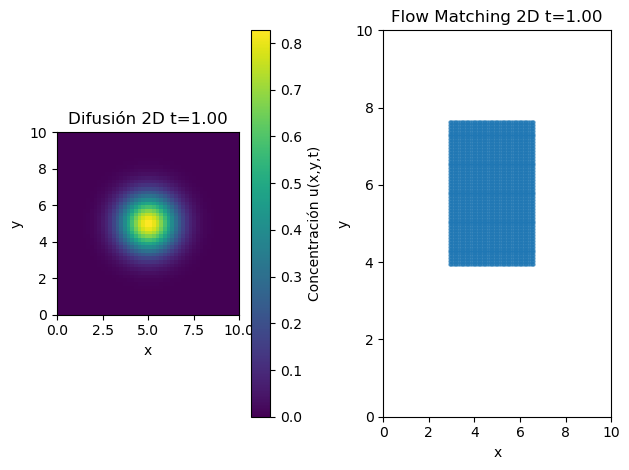

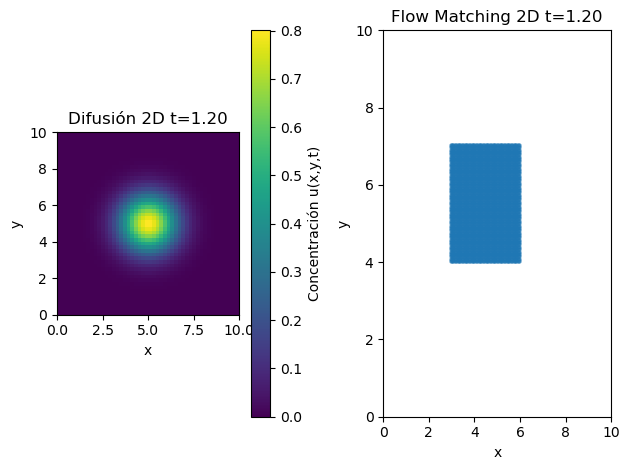

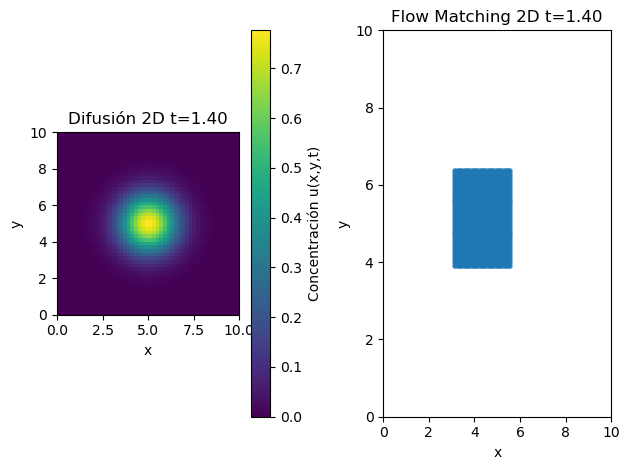

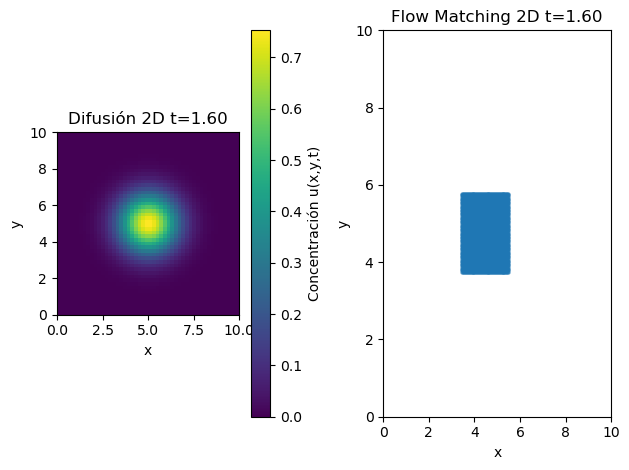

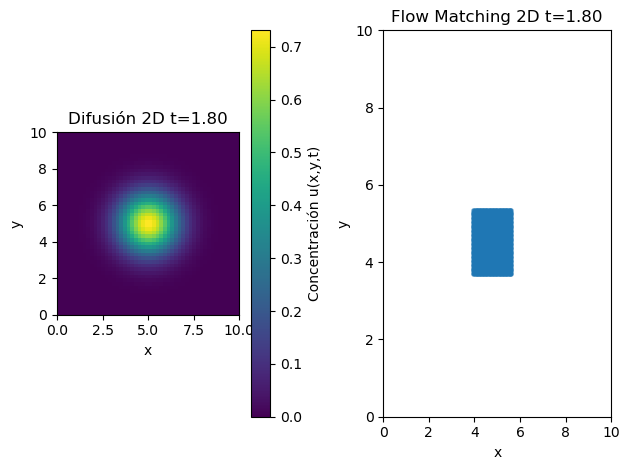

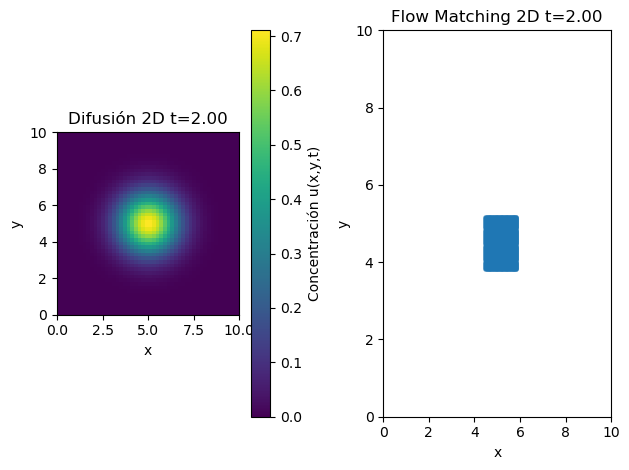

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros generales
Lx, Ly = 10.0, 10.0       # tamaño dominio en x y y
Nx, Ny = 50, 50           # puntos espaciales
dx, dy = Lx/(Nx-1), Ly/(Ny-1)
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

T = 2.0                   # tiempo total
dt = 0.001                # paso temporal
Nt = int(T/dt)

D = 0.1                   # coeficiente de difusión

# Condición inicial gaussiana en 2D para difusión
def gauss_2d(X, Y, mux, muy, sigmax, sigmay):
    return np.exp(-0.5 * (((X - mux)/sigmax)**2 + ((Y - muy)/sigmay)**2))

U0 = gauss_2d(X, Y, Lx/2, Ly/2, 1.0, 1.0)

# --- Difusión 2D: diferencias finitas explícitas ---
def diffusion_step_2d(U, D, dt, dx, dy):
    U_new = U.copy()
    coeff_x = D * dt / dx**2
    coeff_y = D * dt / dy**2
    for i in range(1, U.shape[0]-1):
        for j in range(1, U.shape[1]-1):
            U_new[i,j] = U[i,j] + \
                coeff_x * (U[i+1,j] - 2*U[i,j] + U[i-1,j]) + \
                coeff_y * (U[i,j+1] - 2*U[i,j] + U[i,j-1])
    # Condiciones de frontera Dirichlet (0)
    U_new[0,:] = 0
    U_new[-1,:] = 0
    U_new[:,0] = 0
    U_new[:,-1] = 0
    return U_new

# --- Flow Matching 2D ---
# Campo vectorial simple: v(t, x, y) = -lambda * ([x, y] - mu(t))
lambda_ = 1.0

def mu_t(t):
    # centro móvil en trayectoria circular
    r = 2.0
    cx = Lx/2 + r * np.cos(2 * np.pi * t / T)
    cy = Ly/2 + r * np.sin(2 * np.pi * t / T)
    return np.array([cx, cy])

def v_field(t, pos):
    # pos es array shape (N, 2)
    mu = mu_t(t)
    return -lambda_ * (pos - mu)

# RK4 para sistemas 2D
def rk4_step_2d(pos, t, dt, v_func):
    k1 = v_func(t, pos)
    k2 = v_func(t + dt/2, pos + dt/2 * k1)
    k3 = v_func(t + dt/2, pos + dt/2 * k2)
    k4 = v_func(t + dt, pos + dt * k3)
    return pos + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

# Inicialización puntos para flow matching: rejilla uniforme 2D
points = np.vstack([X.ravel(), Y.ravel()]).T

# Inicialización difusión
U = U0.copy()

# Para graficar cada cierto tiempo
plot_steps = Nt // 10

plt.figure(figsize=(12,6))

for n in range(Nt):
    t = n*dt
    # Paso difusión
    U = diffusion_step_2d(U, D, dt, dx, dy)
    # Paso flow matching
    points = rk4_step_2d(points, t, dt, v_field)
    
    if n % plot_steps == 0 or n == Nt-1:
        plt.clf()
        # Difusión 2D
        plt.subplot(1,2,1)
        plt.imshow(U, extent=[0,Lx,0,Ly], origin='lower', cmap='viridis')
        plt.colorbar(label='Concentración u(x,y,t)')
        plt.title(f'Difusión 2D t={t:.2f}')
        plt.xlabel('x')
        plt.ylabel('y')

        # Flow matching: posición de puntos
        plt.subplot(1,2,2)
        plt.scatter(points[:,0], points[:,1], s=5, alpha=0.6)
        plt.title(f'Flow Matching 2D t={t:.2f}')
        plt.xlim(0, Lx)
        plt.ylim(0, Ly)
        plt.xlabel('x')
        plt.ylabel('y')
        
        plt.tight_layout()
        plt.pause(0.1)

plt.show()
